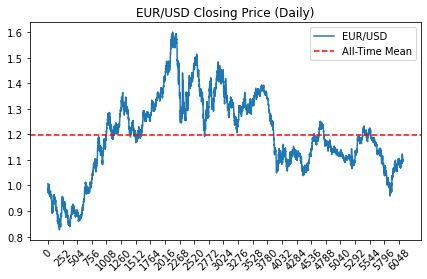

In [26]:
# Import data
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt

# Importing the excel file into the Python interpreter
data = pd.read_excel('Daily_EURUSD_Historical_Data.xlsx')
data=data['<CLOSE>']

plt.figure(figsize=(7, 4))
plt.plot(data, label='EUR/USD')
plt.axhline(y=np.mean(data), color='red', linestyle='--', label='All-Time Mean')
plt.title('EUR/USD Closing Price (Daily)')
plt.legend()

# Set xticks to appear every 252 days
plt.xticks(range(0, len(data), 252), rotation=45)  # 252 days = 1 year in trading days
plt.show()


Text(0.5, 1.0, 'First Difference of EUR/USD Closing Price (Daily)')

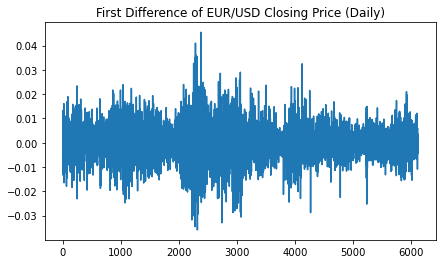

In [27]:
# Difference the data to make it stationary
datadiff = data.diff()
datadiff=datadiff.dropna()

plt.figure(figsize=(7, 4))
plt.plot(datadiff)
plt.title('First Difference of EUR/USD Closing Price (Daily)')

# First-differencing made our data stationary.

In [28]:
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target variable (y)
X = datadiff.values
y = datadiff.shift(-1).values  # Shift the target variable by one day to align with features

# Split the data into training and validation sets
# Do not shuffle - order matters
X_train, X_val, y_train, y_val = train_test_split(X[:-1], y[:-1], test_size=0.2, shuffle=False)


In [30]:
from itertools import product

ps = [0,1,2,3,4,9]
qs = [0,1,2,3,4,9]

order_list = list(product(ps, qs))
# print(order_list)

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [32]:
# Because autocorrelations in both our ACF and PACF plots dont drop abruptly after a certain lag, 
# we suspect we are modeling a complex time series, so we jump straigth to an ARMA(p,q) model
# ACF and PACF have been applied to the differenced series, which is stationary
# General steps: 
#     1) try different models and choose the one with lowest AIC
#     2) Residual analysis: straight line Q-Q plot and uncorrelated residuals?

# AIC 2k – 2ln(L̂)
AICs=[];

for o in range(len(order_list)):
    model = SARIMAX(X_train, order=(order_list[o][0], 0, order_list[o][1]),simple_differencing=False).fit(disp=False)  
    aic = model.aic
    AICs.append([order_list[o], round(aic,4)])

AIC_df = pd.DataFrame(AICs)
AIC_df.columns = ['(p,q)', 'AIC'] #Sort in ascending order, lower AIC is better
AIC_df = AIC_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
display(AIC_df.head())

C:\Users\Owner\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Owner\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Owner\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Owner\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Owner\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarnin

,"(p,q)",AIC
0,"(0, 1)",-33813.0026
1,"(1, 0)",-33812.9781
2,"(0, 0)",-33812.3073
3,"(1, 1)",-33811.1504
4,"(0, 2)",-33811.1000


Text(0.5, 1.0, 'Analysis of Residuals: Q-Q Plot')

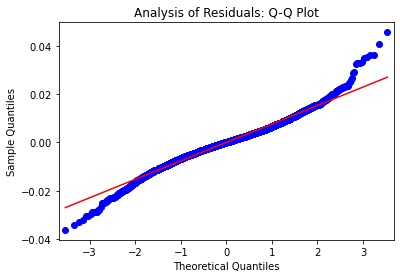

In [33]:
from statsmodels.graphics.gofplots import qqplot

# order_best=AIC_df.iloc[0][0]
order_best=(0,1)

model_1 = SARIMAX(X_train, order=(order_best[0], 0, order_best[1]),simple_differencing=False).fit(disp=False)
aic_1 = model_1.aic
residuals_1 = model_1.resid

qqplot(residuals_1, line='s')
plt.title('Analysis of Residuals: Q-Q Plot')

# As expected, the Q-Q plot indicates fat tails

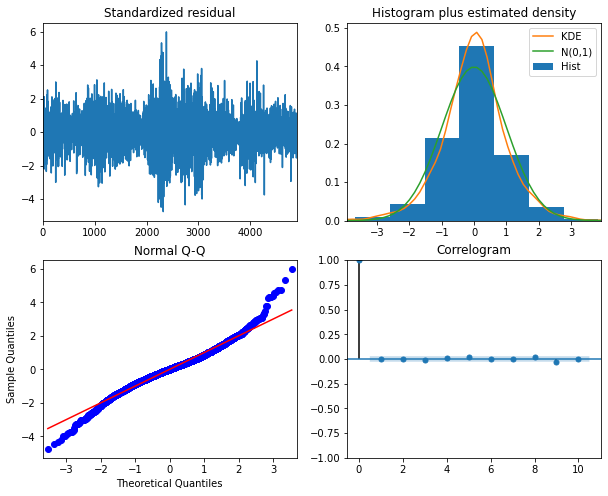

In [34]:
# Further qualitative inspection - looks good!
model_1.plot_diagnostics(figsize=(10, 8));

In [35]:
# Ljung-Box test on first 10 lags
from statsmodels.stats.diagnostic import acorr_ljungbox
# Apply Ljung-Box test on the residuals on 50 lags
lbvalue, pvalue = acorr_ljungbox(residuals_1, np.arange(1, 51, 1))
# Show p-value at each lag
print(pvalue<0.05)   

# The resulting list of p-values shows that each is above 0.05. 
# At each lag, the null hypothesis cannot be rejected (H0=there is no autocorrelaiton up to lag x)
# --> the residuals are independently distributed and uncorrelated, up to lag 50

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]


C:\Users\Owner\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [36]:
# Ljung-Box test on first 252 lags
from statsmodels.stats.diagnostic import acorr_ljungbox
# Apply Ljung-Box test on the residuals on 252 lags
lbvalue, pvalue = acorr_ljungbox(residuals_1, np.arange(1, 253, 1))
# Show p-value at each lag
print(pvalue<0.05)   

# We can reject the null for lags 57 and above

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [37]:
# # How many n for Ljung-Box test? Rule of thumb says ln(n)
# import math
# display(math.log(len(X_train)))

# # Or the forecasting horizon
# display(len(y_val))

# # Or twice the suspected seasonality
# display(252*2)

In [ ]:
# We will not try a range of different customized ARMA models of higher order as suggested by ACF/PACF plots

In [39]:
# Took these from ACF and PACF plots
sig_acf= [9, 27, 46, 55, 59, 60, 66, 93, 101, 104, 115, 123, 124, 128, 130, 131, 133, 137, 157, 179, 182, 198, 213, 218, 241];
sig_pacf= [9, 27, 46, 55, 59, 60, 66, 77, 93, 97, 100, 104, 115, 117, 123, 124, 128, 131, 133, 157, 163, 182, 198, 213, 218, 241];

# subtracted_list = [x - 1 for x in original_list]
sig_acf=[s - 1 for s in sig_acf]
sig_pacf=[s - 1 for s in sig_pacf]

# Create a list of 0s and 1s to indicate which lags to include in the models
coef_key=np.zeros(252)
coef_key[sig_acf] = 1
# Including up to lag 100 here
coef_key=coef_key[:100]
print(coef_key)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0.]


In [14]:
# ARMA(100*,100*)
model_2 = SARIMAX(X_train, order=(coef_key, 0, coef_key),simple_differencing=False).fit(disp=False)
aic_2 = model_2.aic
residuals_2 = model_2.resid

In [300]:
# ARMA(100*,100*) AIC
print(aic_2)

-33825.51647740677


In [40]:
# Including up to lag 50 here
coef_key=np.zeros(252)
coef_key[sig_acf] = 1
coef_key=coef_key[:50]
# print(coef_key)

In [15]:
# ARMA(50*,50*)
model_3 = SARIMAX(X_train, order=(coef_key, 0, coef_key),simple_differencing=False).fit(disp=False)
aic_3 = model_3.aic
residuals_3 = model_3.resid

In [305]:
# ARMA(50*,50*) AIC
print(aic_3)

-33817.41863368858


In [307]:
# Including up to lag 125
coef_key=np.zeros(252)
coef_key[sig_acf] = 1
coef_key=coef_key[:125]
# print(coef_key)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0.]


In [308]:
model_4 = SARIMAX(X_train, order=(coef_key, 0, coef_key),simple_differencing=False).fit(disp=False)
aic_4 = model_4.aic
residuals_4 = model_4.resid

In [309]:
print(aic_4)

-33832.28438124989


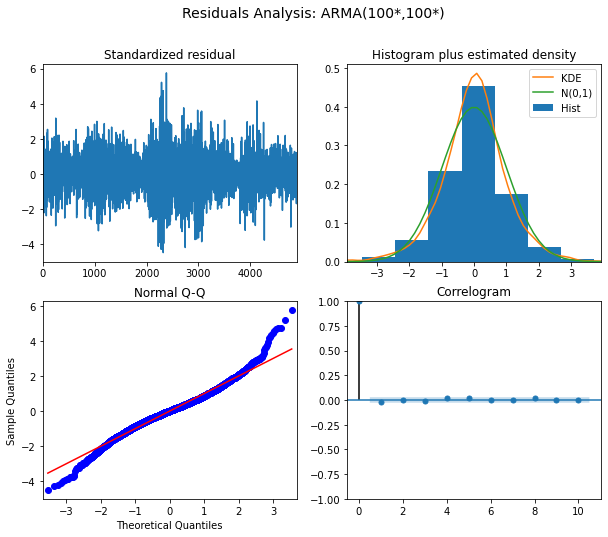

In [334]:
# Further qualitative inspection - looks good!
fig_2=model_2.plot_diagnostics(figsize=(10, 8));
fig_2.suptitle('Residuals Analysis: ARMA(100*,100*)', fontsize=14)
plt.show()

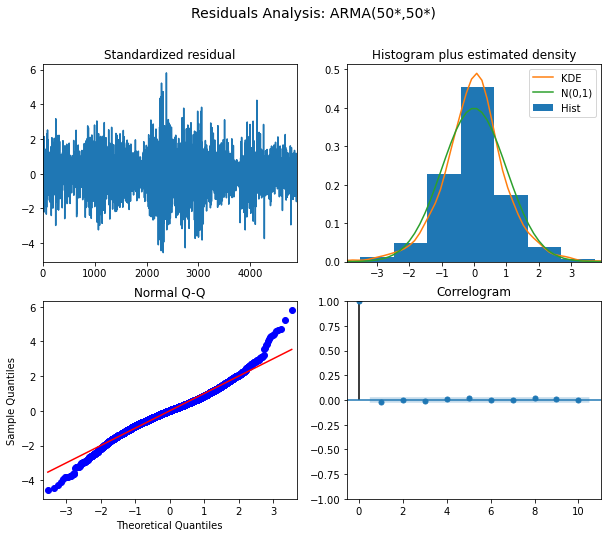

In [335]:
# Further qualitative inspection - looks good!
fig_3=model_3.plot_diagnostics(figsize=(10, 8));
fig_3.suptitle('Residuals Analysis: ARMA(50*,50*)', fontsize=14)
plt.show()

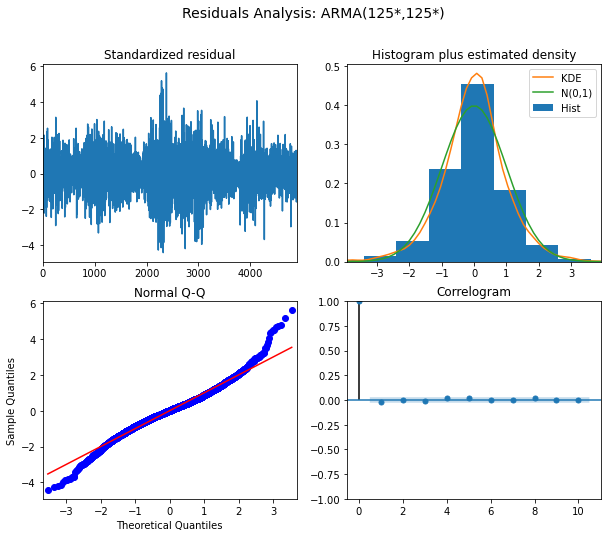

In [336]:
# Further qualitative inspection - looks good!
fig_4=model_4.plot_diagnostics(figsize=(10, 8));
fig_4.suptitle('Residuals Analysis: ARMA(125*,125*)', fontsize=14)
plt.show()

In [316]:
# Ljung-Box test on first 252 lags
from statsmodels.stats.diagnostic import acorr_ljungbox
# Apply Ljung-Box test on the residuals on 252 lags
lbvalue, pvalue = acorr_ljungbox(residuals_2, np.arange(1, 253, 1))
# Show p-value at each lag
print(pvalue<0.05)   


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [317]:
# Ljung-Box test on first 252 lags
from statsmodels.stats.diagnostic import acorr_ljungbox
# Apply Ljung-Box test on the residuals on 252 lags
lbvalue, pvalue = acorr_ljungbox(residuals_3, np.arange(1, 253, 1))
# Show p-value at each lag
print(pvalue<0.05) 

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True  True  True  True  True  True  True
 False False False False  True  True  True  True  True  True  True False
  True  True  True False  True False False False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [318]:
# Ljung-Box test on first 252 lags
from statsmodels.stats.diagnostic import acorr_ljungbox
# Apply Ljung-Box test on the residuals on 252 lags
lbvalue, pvalue = acorr_ljungbox(residuals_4, np.arange(1, 253, 1))
# Show p-value at each lag
print(pvalue<0.05) 

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [326]:
# Make sure they are different
display(residuals_1)
display(residuals_2)
display(residuals_3)
display(residuals_4)

array([-0.0059    , -0.0010391 , -0.01212451, ...,  0.00696256,
        0.00198424,  0.00179681])

array([-0.0059    , -0.00090398, -0.01210025, ...,  0.00734283,
        0.00265405,  0.00159822])

array([-0.0059    , -0.00089977, -0.01209997, ...,  0.00719823,
        0.00230392,  0.00177875])

array([-0.0059    , -0.0009047 , -0.0121019 , ...,  0.00752939,
        0.00272371,  0.00127658])

In [368]:
# Assuming you have trained your SARIMAX model and have new data X_test for prediction
# X_test should be a pandas DataFrame or Series containing the data for prediction

# Make predictions with the trained SARIMAX model
predictions_4 = model_4.forecast(steps=50)



In [370]:
mse_model_4 = np.mean((y_val[:50] - predictions_4*10) ** 2)
display(mse_model_4)

5.256236170629871e-05

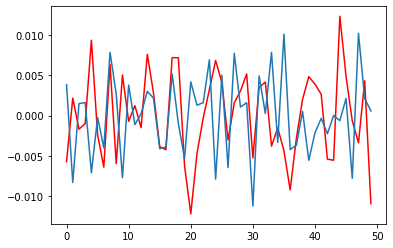

In [372]:
plt.plot(predictions_4*10, color='red')
plt.plot(y_val[:50])

In [373]:
predictions_3 = model_3.forecast(steps=50)

In [374]:
mse_model_3 = np.mean((y_val[:50] - predictions_3*10) ** 2)
display(mse_model_3)

3.565023250107552e-05

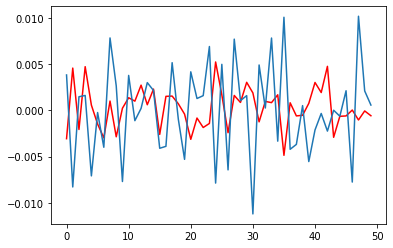

In [375]:
plt.plot(predictions_3*10, color='red')
plt.plot(y_val[:50])

In [376]:
predictions_2 = model_2.forecast(steps=50)

In [377]:
mse_model_2 = np.mean((y_val[:50] - predictions_2*10) ** 2)
display(mse_model_2)

3.838779261935971e-05

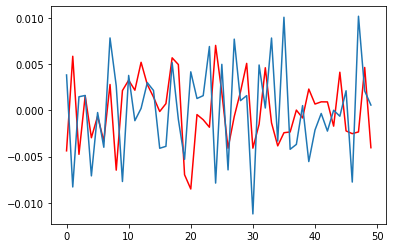

In [378]:
plt.plot(predictions_2*10, color='red')
plt.plot(y_val[:50])

In [16]:
coef_key=np.zeros(252)
coef_key[sig_acf] = 1
coef_key=coef_key[:50]
print(coef_key)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0.]


In [17]:
model_5 = SARIMAX(X_train, order=(0, 0, coef_key),simple_differencing=False).fit(disp=False)
aic_5 = model_5.aic
residuals_5 = model_5.resid

In [18]:
print(aic_5)

-33824.702765558


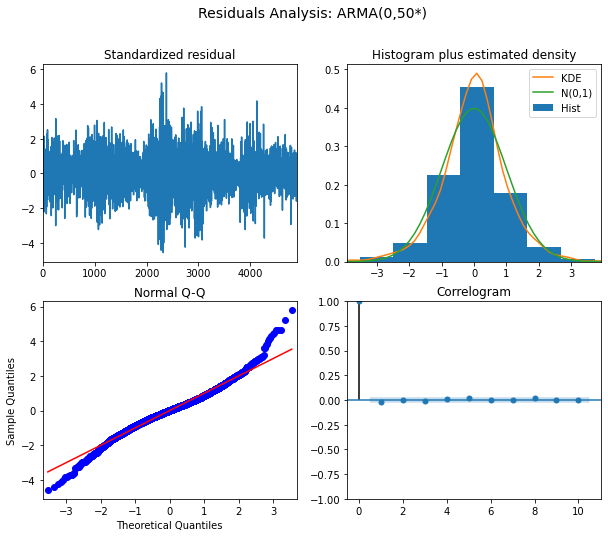

In [21]:
# Further qualitative inspection - looks good!
fig_5=model_5.plot_diagnostics(figsize=(10, 8));
fig_5.suptitle('Residuals Analysis: ARMA(0,50*)', fontsize=14)
plt.show()

In [19]:
coef_key=np.zeros(252)
coef_key[sig_acf] = 1
coef_key=coef_key[:75]
print(coef_key)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [21]:
model_6 = SARIMAX(X_train, order=(0, 0, coef_key),simple_differencing=False).fit(disp=False)
aic_6 = model_6.aic
residuals_6 = model_6.resid

In [1]:
import gc

gc.collect()

24

In [22]:
print(aic_6)

-33834.15954039183


In [24]:
coef_key=np.zeros(252)
coef_key[sig_acf] = 1
coef_key=coef_key[:50]
print(coef_key)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0.]


In [25]:
model_7 = SARIMAX(X_train, order=(coef_key, 0, 0),simple_differencing=False).fit(disp=False)
aic_7 = model_7.aic
residuals_7 = model_7.resid

In [26]:
print(aic_7)

-33826.20044471335


In [22]:
coef_key=np.zeros(252)
coef_key[sig_acf] = 1
coef_key=coef_key[:75]
print(coef_key)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [23]:
model_8 = SARIMAX(X_train, order=(coef_key, 0, 0),simple_differencing=False).fit(disp=False)
aic_8 = model_8.aic
residuals_8 = model_8.resid

In [30]:
print(aic_8)

-33837.41552847759


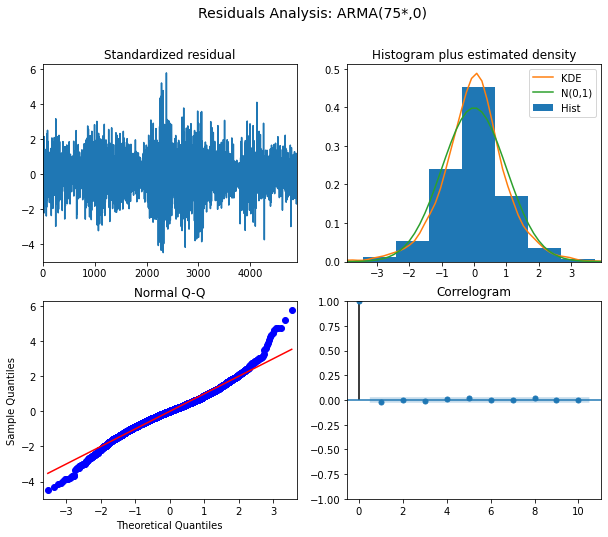

In [25]:
# Further qualitative inspection - looks good!
fig_8=model_8.plot_diagnostics(figsize=(10, 8));
fig_8.suptitle('Residuals Analysis: ARMA(75*,0)', fontsize=14)
plt.show()

In [19]:
predictions_5 = model_5.forecast(steps=50)
mse_model_5 = np.mean((y_val[:50] - predictions_5*10) ** 2)
display(mse_model_5)

3.44179390953958e-05

In [23]:
predictions_6 = model_6.forecast(steps=50)
mse_model_6 = np.mean((y_val[:50] - predictions_6*10) ** 2)
display(mse_model_6)

4.0288678903057156e-05

In [27]:
predictions_7 = model_7.forecast(steps=50)
mse_model_7 = np.mean((y_val[:50] - predictions_7*10) ** 2)
display(mse_model_7)

3.505973193094169e-05

In [31]:
predictions_8 = model_8.forecast(steps=50)
mse_model_8 = np.mean((y_val[:50] - predictions_8*10) ** 2)
display(mse_model_8)

3.840347075208189e-05

In [46]:
aic_2 = -33825.51647740677   # ARMA(100*,100*)
aic_3 = -33817.41863368858   # ARMA(50*,50*)
aic_4 = -33832.28438124989   # ARMA(125*,125*)
aic_5 = -33824.702765558     # ARMA(0,50*)
aic_6 = -33834.15954039183   # ARMA(0,75*)
aic_7 = -33826.20044471335   # ARMA(50*,0)
aic_8 = -33837.41552847759   # ARMA(75*,0)

AICs_star = {
    '(p,q)': [
        '(0,1)',
        '(100*,100*)',
        '(50*,50*)',
        '(125*,125*)',
        '(0,50*)',
        '(0,75*)',
        '(50*,0)',
        '(75*,0)'
    ],
    
    'AIC': [
        aic_1,
        aic_2,  # ARMA(100*,100*)
        aic_3,  # ARMA(50*,50*)
        aic_4,  # ARMA(125*,125*)
        aic_5,  # ARMA(0,50*)
        aic_6,  # ARMA(0,75*)
        aic_7,  # ARMA(50*,0)
        aic_8   # ARMA(75*,0)
    ]
    
}

# Create DataFrame
df_aicstar = pd.DataFrame(AICs_star)
df_aicstar = df_aicstar.sort_values(by='AIC', ascending=True)

# Print the DataFrame
df_aicstar

,"(p,q)",AIC
7,"(75*,0)",-33837.415528
5,"(0,75*)",-33834.159540
3,"(125*,125*)",-33832.284381
6,"(50*,0)",-33826.200445
1,"(100*,100*)",-33825.516477
4,"(0,50*)",-33824.702766
2,"(50*,50*)",-33817.418634
0,"(0,1)",-33813.002556
